### Clustering data over our trials

In [1]:
from modules import *
import json
import plotly.graph_objects as go
import numpy as np

# Obtenemos datos json con 25 elementos = vanos

path = "../data/"

with open(path+'vanos.json', 'r') as archivo:
    data = json.load(archivo)
    
len(data)
data.remove(data[2])

Initialization 0
Initialization converged: True


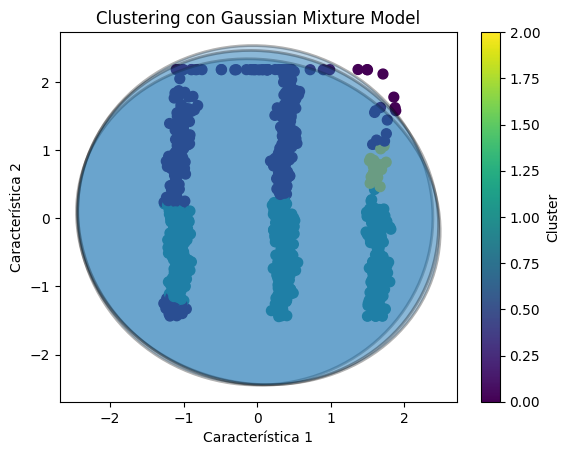

In [ ]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Especificar el número de componentes (clusters) esperados
n_components = 3  # Número de clusters esperado (ajustar según tus necesidades)
X = scale_conductor(cropped_conds[0:2,:]).T

# Crear y ajustar el modelo GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=1, init_params="random", verbose = 1)
gmm.fit(X)

# Obtener las etiquetas de cluster asignadas a cada punto
labels = gmm.predict(X)

def plot_gmm_clusters(gmm, X):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title('Clustering con Gaussian Mixture Model')
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.colorbar(label='Cluster')

    for i in range(gmm.n_components):
        covariances = gmm.covariances_[i][:2, :2]  # Obtener la matriz de covarianza (2x2) del componente i
        mean = gmm.means_[i][:2]  # Obtener la media (centroid) del componente i
        # Calcular los eigenvalores y eigenvectores de la matriz de covarianza
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)
        # Calcular el ángulo de rotación de la elipse (en radianes)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        # Crear la elipse con el tamaño y la orientación correctos
        ellipse = Ellipse(mean, 2 * np.sqrt(5.991 * eigenvalues[0]), 2 * np.sqrt(5.991 * eigenvalues[1]),
                        angle=angle, alpha=0.3, edgecolor='black', linewidth=2)
        plt.gca().add_patch(ellipse)

    plt.show()

# Visualizar los clusters con las elipses de covarianza
plot_gmm_clusters(gmm, X)


[1 1 1 ... 2 2 2]


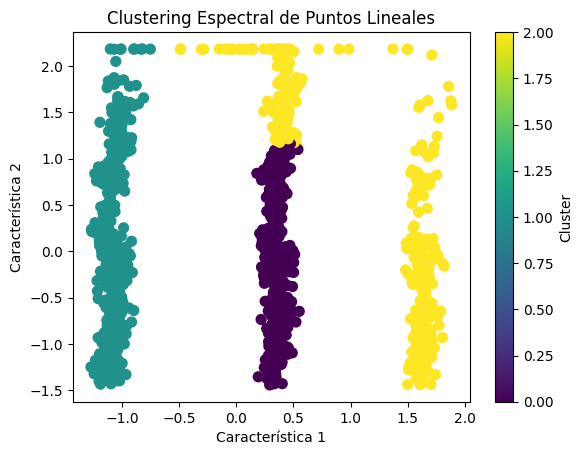

In [ ]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

X = scale_conductor(cropped_conds[0:2,:]).T

# Construir la matriz de afinidad (graffitti)
# affinity_matrix = kneighbors_graph(X, n_neighbors=100, mode='connectivity', include_self=True)
# affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)  # Hacer simétrica

# Aplicar clustering espectral
n_clusters = 3  # Número de clusters esperado (ajustar según tus necesidades)
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=10, n_neighbors=50)
labels = spectral_clustering.fit_predict(X)
print(labels)

# Visualizar los puntos coloreados por sus etiquetas de cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title('Clustering Espectral de Puntos Lineales')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.colorbar(label='Cluster')
plt.show()


Convergence reached at iteration 2


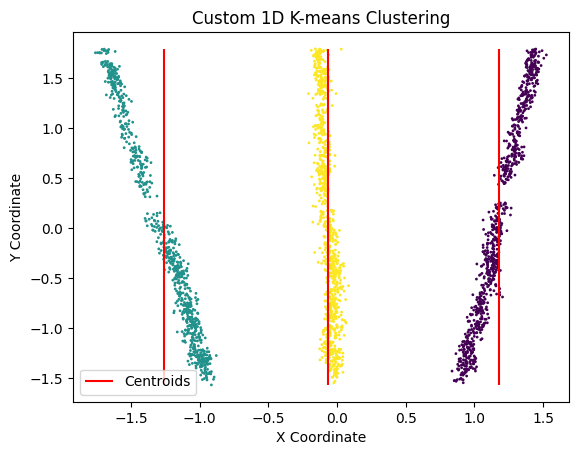

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_centroids(points, n_clusters):
    indices = np.random.choice(points.shape[1], n_clusters, replace=False)
    return points[0, indices]

def assign_clusters(points, centroids):
    distances = np.abs(points[0][:, None] - centroids)
    return np.argmin(distances, axis=1)

def update_centroids(points, labels, n_clusters):
    new_centroids = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_points = points[0, labels == i]
        if cluster_points.size > 0:
            new_centroids[i] = np.mean(cluster_points)
    return new_centroids

def kmeans_clustering(points, n_clusters, max_iterations):
    centroids = initialize_centroids(points, n_clusters)
    for iteration in range(max_iterations):
        labels = assign_clusters(points, centroids)
        new_centroids = update_centroids(points, labels, n_clusters)
        if np.allclose(new_centroids, centroids):
            print(f"Convergence reached at iteration {iteration}")
            break
        centroids = new_centroids
    return labels, centroids

def plot_clusters(points, labels, centroids):
    plt.scatter(points[0], points[1], c=labels, cmap='viridis', s=1)
    plt.vlines(centroids, ymin=np.min(points[1]), ymax=np.max(points[1]), color='red', label='Centroids')
    plt.title('Custom 1D K-means Clustering')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# Assuming cropped_conds is a 2D array
np.random.seed(0)  # For reproducibility

n_clusters = 3
max_iterations = 1000
points = X_scaled

labels, centroids = kmeans_clustering(points, n_clusters, max_iterations)
plot_clusters(points, labels, centroids)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def initialize_centroids(points, n_clusters):
    
    indep = np.random.choice(points[0], n_clusters, replace=False)
    slopes = np.random.normal(size = n_clusters)
    
    centroids = np.zeros(2*n_clusters).reshape(n_clusters, 2)
    centroids[:, 0], centroids[:, 1] = indep, slopes

    return centroids

def distance_to_line(points, line):

    p1, p2 = line[:, 0], line[:, 1]
    
    # Line coefficients A, B, and C
    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = p2[0] * p1[1] - p2[1] * p1[0]
    
    # Calculate the numerator |Ax + By + C|
    numerator = np.abs(A * points[0] + B * points[1] + C)
    # Calculate the denominator sqrt(A^2 + B^2)
    denominator = np.sqrt(A**2 + B**2)
    
    return numerator / denominator

def assign_clusters(points, centroids):

    distances = np.stack([distance_to_line(points, centroid) for centroid in centroids], axis=-1)
    labels = np.argmin(distances, axis=1)
    return labels


def update_centroids(points, labels, n_clusters):
    
    new_centroids = np.zeros(2*n_clusters).reshape(n_clusters, 2)
    
    for i in range(n_clusters):
        cluster_points = points[0, labels == i]
        if cluster_points.size > 0:
            lr = LinearRegression()
            lr.fit(cluster_points[0], cluster_points[1])
            new_centroids[i,0] = np.mean(cluster_points)
    return new_centroids

def kmeans_clustering(points, n_clusters, max_iterations):
    centroids = initialize_centroids(points, n_clusters)
    for iteration in range(max_iterations):
        labels = assign_clusters(points, centroids)
        new_centroids = update_centroids(points, labels, n_clusters)
        if np.allclose(new_centroids, centroids):
            print(f"Convergence reached at iteration {iteration}")
            break
        centroids = new_centroids
    return labels, centroids

def plot_clusters(points, labels, centroids):
    plt.scatter(points[0], points[1], c=labels, cmap='viridis', s=1)
    plt.vlines(centroids, ymin=np.min(points[1]), ymax=np.max(points[1]), color='red', label='Centroids')
    plt.title('Custom 1D K-means Clustering')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# Assuming cropped_conds is a 2D array
np.random.seed(0)  # For reproducibility

n_clusters = 3
max_iterations = 1000
points = X_scaled

labels, centroids = kmeans_clustering(points, n_clusters, max_iterations)
plot_clusters(points, labels, centroids)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

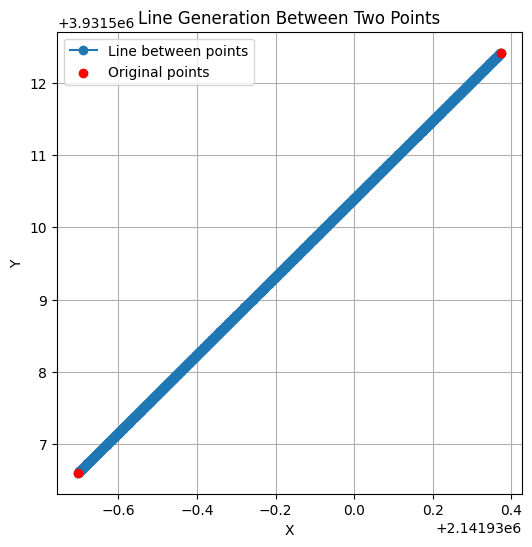

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def initialize_line_centroids(points, n_clusters):
    centroids = []
    for _ in range(n_clusters):
        selected_indices = np.random.choice(points.shape[1], 2, replace=False)
        centroids.append(points[:, selected_indices])
    return centroids



point1 , point2 = initialize_line_centroids(points, 3)[0].T

# Generate line points
x_points, y_points = generate_line_points(point1, point2)

# Plotting the results
plt.figure(figsize=(6, 6))
plt.plot(x_points, y_points, 'o-', label="Line between points")
plt.scatter([point1[0], point2[0]], [point1[1], point2[1]], color='red', zorder=5, label="Original points")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Line Generation Between Two Points")
plt.legend()
plt.grid(True)
plt.show()


Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Itera

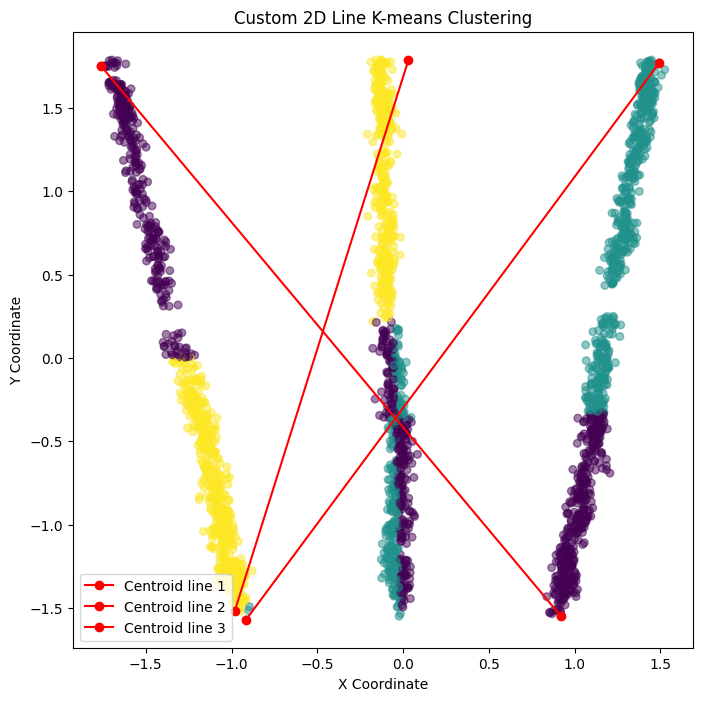

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def generate_line_points(p1, p2, num_points=1000):
    
    # Unpack points
    x1, y1 = p1
    x2, y2 = p2
    
    # Create a range of t values from 0 to 1 to interpolate between the points
    t_values = np.linspace(0, 1, num_points)
    
    # Calculate the x and y coordinates of the points
    x_points = x1 + t_values * (x2 - x1)
    y_points = y1 + t_values * (y2 - y1)
    
    return x_points, y_points

def initialize_line_centroids(points, n_clusters):
    centroids = []
    for _ in range(n_clusters):
        selected_indices = np.random.choice(points.shape[1], 2, replace=False)
        centroids.append(points[:, selected_indices])
    return centroids


def distance_to_line(points, line):

    p1, p2 = line[:, 0], line[:, 1]
    # Line coefficients A, B, and C
    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = p2[0] * p1[1] - p2[1] * p1[0]
    
    # Calculate the numerator |Ax + By + C|
    numerator = np.abs(A * points[0] + B * points[1] + C)
    # Calculate the denominator sqrt(A^2 + B^2)
    denominator = np.sqrt(A**2 + B**2)
    
    return numerator / denominator
    

def assign_clusters(points, centroids):

    distances = np.stack([distance_to_line(points, centroid) for centroid in centroids], axis=-1)
    labels = np.argmin(distances, axis=1)
    return labels

def find_most_distant_points(points):
    # Compute all pairwise distances using broadcasting
    diff = points[:, np.newaxis, :] - points[:, :, np.newaxis]  # Shape: (2, n, n)
    distances = np.linalg.norm(diff, axis=0)  # Shape: (n, n)
    
    # Find the indices of the maximum distance
    max_distance_idx = np.unravel_index(np.argmax(distances), distances.shape)
    
    # Return the two most distant points
    return points[:, max_distance_idx]


def update_centroids(points, labels, n_clusters):
    new_centroids = []
    for i in range(n_clusters):
        cluster_points = points[:, labels == i]
        if cluster_points.size > 0:
            
            # Update centroids as the most distant point from the cluster
            new_centroids.append(find_most_distant_points(cluster_points))
        else:
            # If no points in cluster, reinitialize to avoid errors
            selected_indices = np.random.choice(points.shape[1], 2, replace=False)
            new_centroids.append(points[:, selected_indices])
    return new_centroids

def kmeans_line_clustering(points, n_clusters, max_iterations):
    centroids = initialize_line_centroids(points, n_clusters)
    for iteration in range(max_iterations):
        
        start = time.time()
        
        labels = assign_clusters(points, centroids)
        
        end1 = time.time()
        
        # print("Cluster assignation: ", end1 - start)
        
        new_centroids = update_centroids(points, labels, n_clusters)
        
        end2 = time.time()
        
        # print("Centroid update: ", end2 - end1)
        print("Iteration: ", iteration)
        
        # if np.all([np.allclose(nc, c, atol=1e-5) for nc, c in zip(new_centroids, centroids)]):
        #     print(f"Convergence reached at iteration {iteration}")
            # break
        centroids = new_centroids
    return labels, centroids

def plot_clusters(points, labels, centroids):
    plt.figure(figsize=(8, 8))
    plt.scatter(points[0], points[1], c=labels, cmap='viridis', s=30, alpha=0.5)
    for i, (line_points) in enumerate(centroids):
        plt.plot(line_points[0], line_points[1], 'r-o', label=f'Centroid line {i+1}')
    plt.title('Custom 2D Line K-means Clustering')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# Assuming cropped_conds is a 2D array
np.random.seed(5)  # For reproducibility

n_clusters = 3
max_iterations = 100
points = X_scaled

labels, centroids = kmeans_line_clustering(points, n_clusters, max_iterations)
plot_clusters(points, labels, centroids)


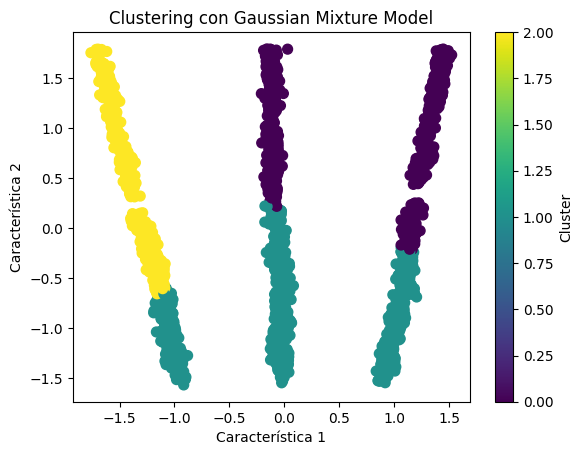

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin


X = X_scaled.T

np.random.seed(224101)  # For reproducibility

kmeans = KMeans(n_clusters=3, algorithm='elkan', init='k-means++', max_iter = 1000)
kmeans.fit(X)

labels = kmeans.predict(X)

# Visualizar los puntos coloreados por sus etiquetas de cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title('Clustering con Gaussian Mixture Model')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.colorbar(label='Cluster')
plt.show()

[[-0.03507679 -1.49311629]
 [ 0.93542263 -1.43798885]
 [-0.95185985 -1.49315197]
 ...
 [-0.06193333  1.73084524]
 [-1.61681034  1.76400752]
 [-0.0888723   1.66288712]]


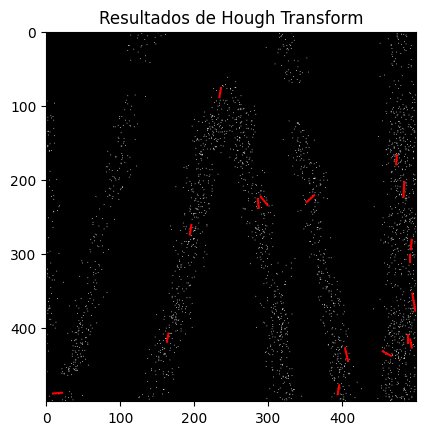

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Generar datos de ejemplo
np.random.seed(0)

X = X_scaled.T

# Preparar imagen para la transformada de Hough
img_size = 500  # Define el tamaño de la imagen
img = np.zeros((img_size, img_size), dtype=np.uint8)
max_val = np.max(X)
scale = img_size / max_val # Escala para mapear coordenadas x, y a la imagen

print(X)

for x, y in X:
    ix, iy = int(x * scale), int(y * scale)
    # print(x*scale)
    if ix < img_size and iy < img_size:
        img[iy, ix] = 255  # Solo establece el punto si está dentro de los límites

# Aplicar la transformada de Hough
lines = cv2.HoughLinesP(img, 1, np.pi / 180, threshold=5, minLineLength=10, maxLineGap=5)

# Visualizar los resultados
plt.imshow(img, cmap='gray')
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        plt.plot([x1, x2], [y1, y2], 'r')
plt.title('Resultados de Hough Transform')
plt.show()


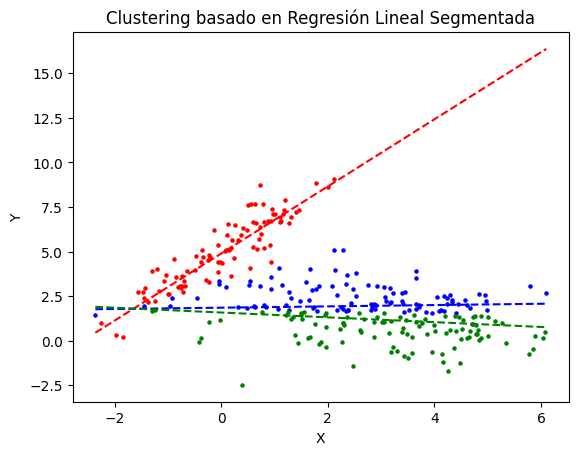

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generar datos de ejemplo (ajusta esto según tus datos)
# np.random.seed(44)
X1 = np.random.randn(100, 1) + np.array([0])
y1 = 2 * X1[:, 0] + np.random.randn(100) + 5
X2 = np.random.randn(100, 1) + np.array([2])
y2 = -X1[:, 0] + np.random.randn(100) + 2
X3 = np.random.randn(100, 1) + np.array([4])
y3 = 0.5 * X1[:, 0] + np.random.randn(100) + 1

# Combinar datos
X = np.vstack([X1, X2, X3])
y = np.concatenate([y1, y2, y3])

# Ajustar modelos de regresión lineal
models = []
for data in [(X1, y1), (X2, y2), (X3, y3)]:
    lr = LinearRegression()
    lr.fit(data[0], data[1])
    models.append(lr)

# Asignar puntos a la línea más cercana
labels = []
for xi, yi in zip(X, y):
    errors = [mean_squared_error([yi], [model.predict(xi.reshape(1, -1))]) for model in models]
    label = np.argmin(errors)
    labels.append(label)

labels = np.array(labels)

# Visualizar resultados
colors = ['red', 'blue', 'green']
for i, color in enumerate(colors):
    # print(X[labels == i], y[labels == i])
    plt.scatter(X[labels == i], y[labels == i], c=color, s = 5)
    line_x = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    line_y = models[i].predict(line_x[:, np.newaxis])
    plt.plot(line_x, line_y, "--", c=color, label = "line")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustering basado en Regresión Lineal Segmentada')
plt.show()
